<a href="https://colab.research.google.com/github/AnkitaSavaliya/AIH/blob/main/AIH/Class/ARFMortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# HOSP_KEY = 'hosp'
# LONG_TITLE_KEY = 'long_title'
# ICD_CODE_KEY = 'icd_code'
# ICD_VERSION_KEY = 'icd_version'
# SEQ_NUM_KEY = 'seq_num'
# SUBJECT_ID_KEY = 'subject_id'
# HADM_ID_KEY = 'hadm_id'
# DISCHTIME_KEY = 'dischtime'
# DEATHTIME_KEY = 'deathtime'
# ADMIT_PROVIDER_ID_KEY = 'admit_provider_id'
# DISCHARGE_LOCATION_KEY = 'discharge_location'
# LANGUAGE_KEY = 'language'
# EDREGTIME_KEY = 'edregtime'
# EDOUTTIME_KEY = 'edouttime'
# ADMITTIME_KEY = 'admittime'
# ANCHORE_YEAR_GROUP_KEY = 'anchor_year_group'
# ANCHOR_YEAR_KEY = 'anchor_year'
# ANCHOR_AGE_KEY = 'anchor_age'
# RACE_KEY = 'race'
# GENDER_KEY = 'gender'
# DOB_KEY = 'dob'
# DOD_KEY = 'dod'
# LAST_CAREUNIT_KEY = 'last_careunit'
# INTIME_KEY = 'intime'
# OUTTIME_KEY = 'outtime'
# LOS_KEY = 'los'
# STAY_ID_KEY = 'stay_id'
# LABEL_KEY = 'label'
# VALUE_KEY = 'value'
# VALUENUM_KEY = 'valuenum'
# VALUEUOM_KEY = 'valueuom'
# FLAG_KEY = 'flag'
# REF_RANGE_LOWER_KEY = 'ref_range_lower'
# REF_RANGE_UPPER_KEY = 'ref_range_upper'
# PRIORITY_KEY = 'priority'
# SPECIMEN_ID_KEY = 'specimen_id'
# ORDER_PROVIDER_ID_KEY = 'order_provider_id'
# STORETIME_KEY = 'storetime'
# COMMENTS_KEY = 'comments'
# ITEMID_KEY = 'itemid'
# CATEGORY_KEY = 'category'
# FLUID_KEY = 'fluid'
# LABEVENT_ID_KEY = 'labevent_id'
# CHARTTIME_KEY = 'charttime'
# ADMIT_AGE_KEY = 'admit_age'
# FIRST_CAREUNIT_KEY = 'first_careunit'
# ADMISSION_TYPE_KEY = 'admission_type'
# HOSPITAL_EXPIRE_FLAG_KEY = 'hospital_expire_flag'
# INSURANCE_KEY = 'insurance'
# ADMISSION_LOCATION_KEY = 'admission_location'
# MARITAL_STATUS_KEY = 'marital_status'

In [3]:
def pandas_read_csv(mimic_csv_file_name: str, low_memory=False, chunksize=None) -> pd.DataFrame:
    """
    Read CSV file from MIMIC-IV dataset into a pandas DataFrame.
    """
    # change path of mimic data directory (in mounted Google Drive)
    mimic_root_dir_path = '/content/drive/MyDrive/Colab Notebooks/AIH/MIMIC-IV/'
    file_path = mimic_root_dir_path + mimic_csv_file_name
    return pd.read_csv(file_path, low_memory=low_memory, chunksize=chunksize)

    # # mimic-iv is split into 'hosp' and 'icu' directories
    # hosp_dir_path = os.path.join(mimic_root_dir_path, ICU_KEY)
    # icu_dir_path = os.path.join(mimic_root_dir_path, HOSP_KEY)

    # # check if desired file name exists in either 'hosp' or 'icu' directory,
    # # else raise FileNotFoundError
    # if os.path.exists(os.path.join(hosp_dir_path, mimic_csv_file_name)):
    #     file_path = os.path.join(hosp_dir_path, mimic_csv_file_name)
    #     return pd.read_csv(file_path, low_memory=low_memory, chunksize=chunksize)

    # elif os.path.exists(os.path.join(icu_dir_path, mimic_csv_file_name)):
    #     file_path = os.path.join(icu_dir_path, mimic_csv_file_name)
    #     return pd.read_csv(file_path, low_memory=low_memory, chunksize=chunksize)

    # else:
    #     raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), mimic_csv_file_name)

In [55]:
dg = pandas_read_csv("d_icd_diagnoses.csv.gz")
dg = dg[dg.apply(lambda x: 'Acute respiratory failure' in x[LONG_TITLE_KEY], axis=1)]
dg.drop_duplicates(inplace=True)
display(dg)

<ipython-input-55-19d61132d1f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg.drop_duplicates(inplace=True)


,icd_code,icd_version,long_title
5337,51851,9,Acute respiratory failure following trauma and...
5342,51881,9,Acute respiratory failure
26977,J960,10,Acute respiratory failure
26978,J9600,10,"Acute respiratory failure, unspecified whether..."
26979,J9601,10,Acute respiratory failure with hypoxia
26980,J9602,10,Acute respiratory failure with hypercapnia


In [85]:
# Identify ICD codes related to acute respiratory failure (ARF)
respiratory_failure_icd_codes = dg[dg['long_title'].str.contains('acute respiratory failure', case=False)]['icd_code']
respiratory_failure_icd_codes.unique()

array(['51851', '51881', 'J960', 'J9600', 'J9601', 'J9602'], dtype=object)

In [59]:
# Read dictionary of ICD diagnosis codes and filter to include codes which long title includes 'sepsis'.
# Afterward, drop long title column and drop duplicates.
df = pandas_read_csv("d_icd_diagnoses.csv.gz")
df = df[df.apply(lambda x: 'Acute respiratory failure' in x['long_title'], axis=1)]
df.drop(columns=['long_title'], inplace=True)
df.drop_duplicates(inplace=True)

print(df)

print('-----------')

# Merge filtered 'sepsis' ICD codes with diagnoses ICD table.
# MIMIC-IV contains both ICD-9 and ICD-10, thus we need to merge on both code and version.
# Afterward, drop code and version columns and drop duplicates.
#merge using respiratory_failure_icd_codes

# # Identify ICD codes related to acute respiratory failure (ARF)
# respiratory_failure_icd_codes = dg[dg['long_title'].str.contains('acute respiratory failure', case=False)]['icd_code']
# respiratory_failure_icd_codes

df = df.merge(pandas_read_csv('diagnoses_icd.csv.gz'), on=['icd_code', 'icd_version'], how='inner')
df.drop(columns=['icd_code', 'icd_version', 'seq_num'], inplace=True)
df.drop_duplicates(inplace=True)
print(df)

<ipython-input-59-4f66c772cd54>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=[LONG_TITLE_KEY], inplace=True)
<ipython-input-59-4f66c772cd54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


      icd_code  icd_version
5337     51851            9
5342     51881            9
26977     J960           10
26978    J9600           10
26979    J9601           10
26980    J9602           10
-----------
       subject_id   hadm_id
0        10021487  28998349
1        10056223  27715453
2        10103748  21580264
3        10109085  25779388
4        10159535  22517101
...           ...       ...
23941    19915864  27877414
23948    19973580  27373602
23949    19975796  22651802
23952    19983535  25147398
23954    19984218  26045738

[22650 rows x 2 columns]


In [75]:
# # Define respiratory-related lab test keywords
# respiratory_tests = ['oxygen', 'pao2', 'spo2', 'co2', 'ph', 'bicarbonate', 'lactate']

# # Load d_labitems.csv.gz
# d_lab_items =  pandas_read_csv('d_labitems.csv.gz')

# # Filter only blood-based respiratory-related tests
# d_lab_items = d_lab_items[(d_lab_items[FLUID_KEY] == 'Blood')]

# # Keep only tests matching respiratory-related keywords
# d_lab_items = d_lab_items[d_lab_items[LABEL_KEY].str.lower().str.contains('|'.join(respiratory_tests), na=False)]

# # Drop unnecessary columns
# d_lab_items.drop(columns=[FLUID_KEY, CATEGORY_KEY], inplace=True, errors='ignore')

# # Remove duplicates and reset index
# d_lab_items.drop_duplicates(inplace=True)
# d_lab_items.reset_index(drop=True, inplace=True)
# d_lab_items.head()

,itemid,label
0,50803,"Calculated Bicarbonate, Whole Blood"
1,50804,Calculated Total CO2
2,50813,Lactate
3,50816,Oxygen
4,50817,Oxygen Saturation


In [87]:
# Load diagnoses_icd.csv.gz
df = pandas_read_csv("diagnoses_icd.csv.gz")

# Extract ICD codes for acute respiratory failure
respiratory_failure_icd_codes = ['51851', '51881', 'J960', 'J9600', 'J9601', 'J9602']

# Filter diagnoses table using extracted ICD codes and create a new DataFrame (to avoid SettingWithCopyWarning)
df = df[df['icd_code'].isin(respiratory_failure_icd_codes)].copy()
# Drop unnecessary columns safely
df.drop(columns=['seq_num', 'icd_code', 'icd_version'], inplace=True, errors='ignore')
# Remove duplicates
df.drop_duplicates(inplace=True)

df.head()

,subject_id,hadm_id
117,10000690,25860671
756,10001843,26133978
927,10001884,26184834
1436,10002114,27793700
1547,10002155,28994087


In [195]:
# Define respiratory-related lab test keywords
#respiratory_tests = ['oxygen', 'pao2', 'spo2', 'co2', 'ph', 'bicarbonate', 'lactate']
respiratory_tests = ['Oxygen Saturation', 'Oxygen', 'pH', 'pCO2', 'Bicarbonate', 'Lactate', 'Calculated Bicarbonate, Whole Blood']

# # Load and filter d_labitems.csv.gz for relevant respiratory tests
# d_lab_items = pandas_read_csv('d_labitems.csv.gz')
# d_lab_items = d_lab_items[d_lab_items['fluid'] == 'Blood']
# d_lab_items = d_lab_items[d_lab_items['label'].str.lower().str.contains('|'.join(respiratory_tests), na=False)]
# d_lab_items.drop(columns=['fluid', 'category'], inplace=True, errors='ignore')
# d_lab_items = d_lab_items.drop_duplicates().reset_index(drop=True)

d_lab_items = pandas_read_csv('d_labitems.csv.gz')
#d_lab_items = d_lab_items[(d_lab_items['fluid'] == 'Blood')]
d_lab_items = d_lab_items[d_lab_items.apply(lambda x: str(x['label']).lower().strip() in respiratory_tests, axis=1)]
d_lab_items.drop(columns=['fluid', 'category'], inplace=True)
d_lab_items.drop_duplicates(inplace=True)
d_lab_items.reset_index(drop=True, inplace=True)

d_lab_items.head()

,itemid,label


In [200]:
respiratory_tests = [
    'oxygen saturation', 'oxygen', 'ph', 'pco2',
    'bicarbonate', 'lactate', 'calculated bicarbonate, whole blood'
]

d_lab_items = pandas_read_csv('d_labitems.csv.gz')

# Afterward, drop fluid and category columns and drop duplicates.
d_lab_items = d_lab_items[(d_lab_items['fluid'] == 'Blood')]
d_lab_items = d_lab_items[d_lab_items.apply(lambda x: str(x['label']).lower().strip() in respiratory_tests, axis=1)]
d_lab_items.drop(columns=['fluid', 'category'], inplace=True)
d_lab_items.drop_duplicates(inplace=True)
d_lab_items.reset_index(drop=True, inplace=True)

print(d_lab_items)


   itemid                                label
0   50803  Calculated Bicarbonate, Whole Blood
1   50813                              Lactate
2   50816                               Oxygen
3   50817                    Oxygen Saturation
4   50818                                 pCO2
5   50820                                   pH
6   50882                          Bicarbonate
7   52442                              Lactate
8   53154                              Lactate


In [201]:
def get_arf_raw_data(archive_and_download=False) -> pd.DataFrame:
    """
    Read, filter, merge, and return (as a pandas DataFrame) MIMIC-IV data for patients diagnosed with acute respiratory failure.
    """

    # Load diagnoses_icd.csv.gz
    df = pandas_read_csv("diagnoses_icd.csv.gz")
    # Extract ICD codes for acute respiratory failure
    respiratory_failure_icd_codes = ['51851', '51881', 'J960', 'J9600', 'J9601', 'J9602']
    # Filter diagnoses table using extracted ICD codes and create a new DataFrame (to avoid SettingWithCopyWarning)
    df = df[df['icd_code'].isin(respiratory_failure_icd_codes)].copy()
    # Drop unnecessary columns safely
    df.drop(columns=['seq_num', 'icd_code', 'icd_version'], inplace=True, errors='ignore')
    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Merge with admissions table
    df = df.merge(pandas_read_csv('admissions.csv.gz'), on=['subject_id', 'hadm_id'], how='inner')
    df.drop(columns=['dischtime', 'deathtime', 'admit_provider_id', 'discharge_location', 'language',
                     'edregtime', 'edouttime'], inplace=True, errors='ignore')
    df = df.drop_duplicates().reset_index(drop=True)

    # Merge with patients table
    df = df.merge(pandas_read_csv('patients.csv.gz'), on=['subject_id'], how='inner')
    df.drop(columns=['dod', 'anchor_year_group'], inplace=True, errors='ignore')
    df = df.drop_duplicates().reset_index(drop=True)

    # Merge with ICU stays table
    df = df.merge(pandas_read_csv('icustays.csv.gz'), on=['subject_id', 'hadm_id'], how='inner')
    df.drop(columns=['last_careunit', 'intime', 'outtime', 'los', 'stay_id'], inplace=True, errors='ignore')
    df = df.drop_duplicates().reset_index(drop=True)

    # Define respiratory-related lab test keywords
    #respiratory_tests = ['oxygen', 'pao2', 'spo2', 'co2', 'ph', 'bicarbonate', 'lactate']
    respiratory_tests = [
        'oxygen saturation', 'oxygen', 'ph', 'pco2',
        'bicarbonate', 'lactate', 'calculated bicarbonate, whole blood'
    ]

    d_lab_items = pandas_read_csv('d_labitems.csv.gz')

    # Afterward, drop fluid and category columns and drop duplicates.
    d_lab_items = d_lab_items[(d_lab_items['fluid'] == 'Blood')]
    d_lab_items = d_lab_items[d_lab_items.apply(lambda x: str(x['label']).lower().strip() in respiratory_tests, axis=1)]
    d_lab_items.drop(columns=['fluid', 'category'], inplace=True)
    d_lab_items.drop_duplicates(inplace=True)
    d_lab_items.reset_index(drop=True, inplace=True)

    # Create a set of unique subject_id and hadm_id combinations
    subject_hadm_ids = df[['subject_id', 'hadm_id']].drop_duplicates().reset_index(drop=True)

    # Process labevents.csv.gz in chunks to avoid memory issues
    chunks = []
    for chunk in pandas_read_csv('labevents.csv.gz', low_memory=False, chunksize=10**7):
        # Drop unnecessary columns
        chunk.drop(columns=['labevent_id', 'value', 'valueuom', 'flag', 'ref_range_lower', 'ref_range_upper',
                            'priority', 'specimen_id', 'order_provider_id', 'storetime', 'comments'],
                   inplace=True, errors='ignore')

        # Filter by respiratory-related lab test items
        chunk = chunk.merge(d_lab_items, on=['itemid'], how='inner')
        chunk.drop(columns=['itemid'], inplace=True, errors='ignore')

        # Keep only rows for patients with acute respiratory failure
        chunk = chunk.merge(subject_hadm_ids, on=['subject_id', 'hadm_id'], how='inner')

        # Sort by subject_id, hadm_id, and charttime
        chunk.sort_values(by=['subject_id', 'hadm_id', 'charttime'], inplace=True)

        # Aggregate by median value per subject_id, hadm_id, and label
        chunk = chunk.groupby(['subject_id', 'hadm_id', 'label'])['valuenum'].median().reset_index()

        chunks.append(chunk)

    # Combine all processed lab event chunks and merge with the main dataset
    if chunks:
        df = df.merge(pd.concat(chunks, ignore_index=True), on=['subject_id', 'hadm_id'], how='inner')

    # Drop duplicates and reset index
    df = df.drop_duplicates(subset=['subject_id', 'hadm_id', 'label']).reset_index(drop=True)

    return df

In [202]:
arf_raw_data = get_arf_raw_data()
arf_raw_data.head(), arf_raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            83237 non-null  int64  
 1   hadm_id               83237 non-null  int64  
 2   admittime             83237 non-null  object 
 3   admission_type        83237 non-null  object 
 4   admission_location    83237 non-null  object 
 5   insurance             81768 non-null  object 
 6   marital_status        72965 non-null  object 
 7   race                  83237 non-null  object 
 8   hospital_expire_flag  83237 non-null  int64  
 9   gender                83237 non-null  object 
 10  anchor_age            83237 non-null  int64  
 11  anchor_year           83237 non-null  int64  
 12  first_careunit        83237 non-null  object 
 13  label                 83237 non-null  object 
 14  valuenum              83213 non-null  float64
dtypes: float64(1), int6

(   subject_id   hadm_id            admittime admission_type  \
 0    10000690  25860671  2150-11-02 18:02:00       EW EMER.   
 1    10000690  25860671  2150-11-02 18:02:00       EW EMER.   
 2    10000690  25860671  2150-11-02 18:02:00       EW EMER.   
 3    10001843  26133978  2134-12-05 00:10:00         URGENT   
 4    10001843  26133978  2134-12-05 00:10:00         URGENT   
 
        admission_location insurance marital_status   race  \
 0          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
 1          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
 2          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
 3  TRANSFER FROM HOSPITAL  Medicare         SINGLE  WHITE   
 4  TRANSFER FROM HOSPITAL  Medicare         SINGLE  WHITE   
 
    hospital_expire_flag gender  anchor_age  anchor_year  \
 0                     0      F          86         2150   
 1                     0      F          86         2150   
 2                     0      F          86         2150   


In [203]:
arf_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            83237 non-null  int64  
 1   hadm_id               83237 non-null  int64  
 2   admittime             83237 non-null  object 
 3   admission_type        83237 non-null  object 
 4   admission_location    83237 non-null  object 
 5   insurance             81768 non-null  object 
 6   marital_status        72965 non-null  object 
 7   race                  83237 non-null  object 
 8   hospital_expire_flag  83237 non-null  int64  
 9   gender                83237 non-null  object 
 10  anchor_age            83237 non-null  int64  
 11  anchor_year           83237 non-null  int64  
 12  first_careunit        83237 non-null  object 
 13  label                 83237 non-null  object 
 14  valuenum              83213 non-null  float64
dtypes: float64(1), int6

In [204]:
arf_raw_data.head()

,subject_id,hadm_id,admittime,admission_type,admission_location,insurance,marital_status,race,hospital_expire_flag,gender,anchor_age,anchor_year,first_careunit,label,valuenum
0,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),Bicarbonate,34.00
1,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),pCO2,52.00
2,10000690,25860671,2150-11-02 18:02:00,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,2150,Medical Intensive Care Unit (MICU),pH,7.45
3,10001843,26133978,2134-12-05 00:10:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,73,2131,Medical/Surgical Intensive Care Unit (MICU/SICU),Bicarbonate,28.50
4,10001843,26133978,2134-12-05 00:10:00,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,73,2131,Medical/Surgical Intensive Care Unit (MICU/SICU),Lactate,2.40


In [205]:
arf_raw_data['first_careunit'].unique()

array(['Medical Intensive Care Unit (MICU)',
       'Medical/Surgical Intensive Care Unit (MICU/SICU)',
       'Coronary Care Unit (CCU)', 'Trauma SICU (TSICU)',
       'Neuro Surgical Intensive Care Unit (Neuro SICU)',
       'Surgical Intensive Care Unit (SICU)', 'Neuro Intermediate',
       'Cardiac Vascular Intensive Care Unit (CVICU)', 'Neuro Stepdown',
       'Intensive Care Unit (ICU)', 'Surgery/Vascular/Intermediate',
       'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg'], dtype=object)

In [206]:
 # create copy of raw sepsis data
df_analyze = arf_raw_data.copy()
# Convert admit time to datetime and calculate age at admission using MIMIC-IV
# anchor year and anchor age. Finally, drop unnecessary columns.
df_analyze['admittime'] = pd.to_datetime(df_analyze['admittime'])
#df_analyze['admit_age'] = (df_analyze['admittime'].dt.year - df_analyze['anchor_year']) - df_analyze['anchor_age']
df_analyze['admit_age'] = df_analyze['anchor_age'] + (df_analyze['admittime'].dt.year - df_analyze['anchor_year'])
df_analyze.drop(columns=['admittime', 'anchor_year', 'anchor_age'], inplace=True)

# Replace race values with simplified values
df_analyze['race'].replace(regex=r"ASIAN\D*", value='ASIAN', inplace=True)
df_analyze['race'].replace(regex=r"WHITE\D*", value='WHITE', inplace=True)
df_analyze['race'].replace(regex=r"HISPANIC\D*", value='HISPANIC/LATINO', inplace=True)
df_analyze['race'].replace(regex=r"BLACK\D*", value='BLACK/AFRICAN AMERICAN', inplace=True)
df_analyze['race'].replace(
    ['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
    value='OTHER/UNKNOWN', inplace=True)

# Replace first care unit with simplified values
df_analyze['first_careunit'].replace(regex=r"Medical/Surgical\D*", value='MICU, SICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Medical\D*", value='MICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Neuro\D*", value='NSICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Cardiac\D*", value='CVICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Coronary\D*", value='CCU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Trauma SICU\D*", value='TSICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Surgical\D*", value='SICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Intensive Care Unit\D*", value='ICU', inplace=True)
df_analyze['first_careunit'].replace(
    ['Surgery/Vascular/Intermediate', 'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg', 'Neuro Stepdown'],
    value='OTHERICU', inplace=True)

df_analyze['first_careunit'] = df_analyze['first_careunit'].str.split(', ', expand=False).reset_index(drop=True)
df_analyze = df_analyze.join(pd.get_dummies(df_analyze['first_careunit'].apply(pd.Series).stack(), dtype=int).groupby(level=0).sum(),
              how='outer')

# Drop old unnecessary first care unit column
df_analyze.drop(columns=['first_careunit'], inplace=True)

df_analyze.head()

,subject_id,hadm_id,admission_type,admission_location,insurance,marital_status,race,hospital_expire_flag,gender,label,valuenum,admit_age,CCU,CVICU,ICU,MICU,NSICU,OTHERICU,SICU,TSICU
0,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,Bicarbonate,34.00,86,0,0,0,1,0,0,0,0
1,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,pCO2,52.00,86,0,0,0,1,0,0,0,0
2,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,pH,7.45,86,0,0,0,1,0,0,0,0
3,10001843,26133978,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,Bicarbonate,28.50,76,0,0,0,1,0,0,1,0
4,10001843,26133978,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,Lactate,2.40,76,0,0,0,1,0,0,1,0


In [207]:
# First we group by subject id and hospital admission id and aggregate lab event results into a list
tmp = df_analyze.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index(
    drop=True)

# Drop old lab event result columns
df_analyze.drop(columns=['label', 'valuenum'], inplace=True)

# Merge temporary aggregated list of results with data
df_analyze = df_analyze.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')

del tmp

In [208]:
df_analyze.head()

,subject_id,hadm_id,admission_type,admission_location,insurance,marital_status,race,hospital_expire_flag,gender,admit_age,CCU,CVICU,ICU,MICU,NSICU,OTHERICU,SICU,TSICU,label,valuenum
0,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,0,0,0,1,0,0,0,0,"[Bicarbonate, pCO2, pH]","[34.0, 52.0, 7.45]"
1,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,0,0,0,1,0,0,0,0,"[Bicarbonate, pCO2, pH]","[34.0, 52.0, 7.45]"
2,10000690,25860671,EW EMER.,EMERGENCY ROOM,Medicare,WIDOWED,WHITE,0,F,86,0,0,0,1,0,0,0,0,"[Bicarbonate, pCO2, pH]","[34.0, 52.0, 7.45]"
3,10001843,26133978,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,76,0,0,0,1,0,0,1,0,"[Bicarbonate, Lactate, Oxygen, Oxygen Saturati...","[28.5, 2.4, 60.0, 81.0, 72.0, 7.1850000000000005]"
4,10001843,26133978,URGENT,TRANSFER FROM HOSPITAL,Medicare,SINGLE,WHITE,1,M,76,0,0,0,1,0,0,1,0,"[Bicarbonate, Lactate, Oxygen, Oxygen Saturati...","[28.5, 2.4, 60.0, 81.0, 72.0, 7.1850000000000005]"


In [209]:
import itertools
unique_labels = set(itertools.chain.from_iterable(df_analyze['label']))
print(unique_labels)

{'Lactate', 'Oxygen', 'Bicarbonate', 'Oxygen Saturation', 'pH', 'Calculated Bicarbonate, Whole Blood', 'pCO2'}


In [211]:
df_analyze_new = df_analyze[df_analyze.apply(lambda x: len(x['label']) < 8, axis=1)]
df_analyze_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83237 entries, 0 to 83236
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            83237 non-null  int64 
 1   hadm_id               83237 non-null  int64 
 2   admission_type        83237 non-null  object
 3   admission_location    83237 non-null  object
 4   insurance             81768 non-null  object
 5   marital_status        72965 non-null  object
 6   race                  83237 non-null  object
 7   hospital_expire_flag  83237 non-null  int64 
 8   gender                83237 non-null  object
 9   admit_age             83237 non-null  int64 
 10  CCU                   83237 non-null  int64 
 11  CVICU                 83237 non-null  int64 
 12  ICU                   83237 non-null  int64 
 13  MICU                  83237 non-null  int64 
 14  NSICU                 83237 non-null  int64 
 15  OTHERICU              83237 non-null

In [212]:
import itertools

# Step 1: Get all unique labels from the 'label' column
all_labels = sorted(set(itertools.chain.from_iterable(df_analyze['label'])))

# Step 2: Expand 'valuenum' into separate columns, using 'label' as column names
df_analyze = df_analyze.join(pd.DataFrame(df_analyze['valuenum'].to_list(), columns=all_labels), how="outer")

# Step 3: Drop old columns
df_analyze.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True, errors='ignore')

# Step 4: Handle missing values (optional)
df_analyze.fillna(0, inplace=True)  # Replace NaNs with 0 (or another appropriate value)

# Step 5: Verify
print(df_analyze.head())

  admission_type      admission_location insurance marital_status   race  \
0       EW EMER.          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
1       EW EMER.          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
2       EW EMER.          EMERGENCY ROOM  Medicare        WIDOWED  WHITE   
3         URGENT  TRANSFER FROM HOSPITAL  Medicare         SINGLE  WHITE   
4         URGENT  TRANSFER FROM HOSPITAL  Medicare         SINGLE  WHITE   

   hospital_expire_flag gender  admit_age  CCU  CVICU  ...  OTHERICU  SICU  \
0                     0      F         86    0      0  ...         0     0   
1                     0      F         86    0      0  ...         0     0   
2                     0      F         86    0      0  ...         0     0   
3                     1      M         76    0      0  ...         0     1   
4                     1      M         76    0      0  ...         0     1   

   TSICU  Bicarbonate  Calculated Bicarbonate, Whole Blood  Lactate  Oxyge

In [177]:
df_analyze.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4508 entries, 274 to 239429
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            4508 non-null   int64 
 1   hadm_id               4508 non-null   int64 
 2   admission_type        4508 non-null   object
 3   admission_location    4508 non-null   object
 4   insurance             4361 non-null   object
 5   marital_status        3927 non-null   object
 6   race                  4508 non-null   object
 7   hospital_expire_flag  4508 non-null   int64 
 8   gender                4508 non-null   object
 9   admit_age             4508 non-null   int64 
 10  CCU                   4508 non-null   int64 
 11  CVICU                 4508 non-null   int64 
 12  ICU                   4508 non-null   int64 
 13  MICU                  4508 non-null   int64 
 14  NSICU                 4508 non-null   int64 
 15  OTHERICU              4508 non-null   i

In [ ]:
 # create copy of raw sepsis data
df_analyze = arf_raw_data.copy()

len(df_analyze)
# Convert admit time to datetime and calculate age at admission using MIMIC-IV
# anchor year and anchor age. Finally, drop unnecessary columns.
df_analyze['admittime'] = pd.to_datetime(df_analyze['admittime'])
#df_analyze['admit_age'] = (df_analyze['admittime'].dt.year - df_analyze['anchor_year']) - df_analyze['anchor_age']
df_analyze['admit_age'] = df_analyze['anchor_age'] + (df_analyze['admittime'].dt.year - df_analyze['anchor_year'])
df_analyze.drop(columns=['admittime', 'anchor_year', 'anchor_age'], inplace=True)

# Replace race values with simplified values
df_analyze['race'].replace(regex=r"ASIAN\D*", value='ASIAN', inplace=True)
df_analyze['race'].replace(regex=r"WHITE\D*", value='WHITE', inplace=True)
df_analyze['race'].replace(regex=r"HISPANIC\D*", value='HISPANIC/LATINO', inplace=True)
df_analyze['race'].replace(regex=r"BLACK\D*", value='BLACK/AFRICAN AMERICAN', inplace=True)
df_analyze['race'].replace(
    ['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
    value='OTHER/UNKNOWN', inplace=True)

# Replace first care unit with simplified values
df_analyze['first_careunit'].replace(regex=r"Medical/Surgical\D*", value='MICU, SICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Medical\D*", value='MICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Neuro\D*", value='NSICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Cardiac\D*", value='CVICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Coronary\D*", value='CCU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Trauma SICU\D*", value='TSICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Surgical\D*", value='SICU', inplace=True)
df_analyze['first_careunit'].replace(regex=r"Intensive Care Unit\D*", value='ICU', inplace=True)
df_analyze['first_careunit'].replace(
    ['Surgery/Vascular/Intermediate', 'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg', 'Neuro Stepdown'],
    value='OTHERICU', inplace=True)

df_analyze['first_careunit'] = df_analyze['first_careunit'].str.split(', ', expand=False).reset_index(drop=True)
df_analyze = df_analyze.join(pd.get_dummies(df_analyze['first_careunit'].apply(pd.Series).stack(), dtype=int).groupby(level=0).sum(),
              how='outer')

# Drop old unnecessary first care unit column
df_analyze.drop(columns=['first_careunit'], inplace=True)

# Below code creates separate columns for each CBC lab event result

# First we group by subject id and hospital admission id and aggregate lab event results into a list
tmp = df_analyze.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index(
    drop=True)

# Drop old lab event result columns
df_analyze.drop(columns=['label', 'valuenum'], inplace=True)

# Merge temporary aggregated list of results with data
df_analyze = df_analyze.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')

del tmp

# Filter to include only data which contain results for all 3 CBC test types
df_analyze = df_analyze[df_analyze.apply(lambda x: len(x['label']) == 3, axis=1)]

# Split aggregated list of lab event results into separate columns, Then, drop unnecessary columns
df_analyze = df_analyze.join(pd.DataFrame(df_analyze['valuenum'].to_list(), columns=df_analyze.iloc[0]['label']), how="outer")
df_analyze.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True)

# One-hot encode category columns: admission type, insurance, race, gender, admission location, and marital status
prefix_cols = ["adm", "ins", 'race', 'gender', 'loc', 'mar']
dummy_cols = ['admission_type', 'insurance', 'race', 'gender', 'admission_location', 'marital_status']
df_analyze = pd.get_dummies(df_analyze, prefix=prefix_cols, columns=dummy_cols, dtype=int)

# Drop duplicates, drop rows with NaN, and reset indices
#df_analyze.drop_duplicates(inplace=True)
#df_analyze.dropna(inplace=True)
df_analyze.reset_index(drop=True, inplace=True)


In [224]:
import warnings
import itertools
# Suppress all warnings
warnings.filterwarnings('ignore')

def process_arf_raw_data(raw_data: pd.DataFrame, archive_and_download=False) -> pd.DataFrame:
    """
    Featurize sepsis raw data. At a high-level:
        - Age at admission is calculated
        - Race columns are simplified to ASIAN, WHITE, HISPANIC, BLACK, and OTHER/UNKNOWN
        - First care units are simplified to MICU, SICU, NSICU, CCU, and TSICU
        - CBC lab event results become separate columns
        - Categorical columns, i.e., race, insurance, gender, etc., are one-hot encoded
    """
    # create copy of raw sepsis data
    df = raw_data.copy()

    # Convert admit time to datetime and calculate age at admission using MIMIC-IV
    # anchor year and anchor age. Finally, drop unnecessary columns.
    df['admittime'] = pd.to_datetime(df['admittime'])
    # df['admit_age'] = (df['admittime'].dt.year - df['anchor_year']) - df['anchor_age']
    df['admit_age'] = df['anchor_age'] + (df['admittime'].dt.year - df['anchor_year'])
    df.drop(columns=['admittime', 'anchor_year', 'anchor_age'], inplace=True)

    # Replace race values with simplified values
    df['race'].replace(regex=r"ASIAN\D*", value='ASIAN', inplace=True)
    df['race'].replace(regex=r"WHITE\D*", value='WHITE', inplace=True)
    df['race'].replace(regex=r"HISPANIC\D*", value='HISPANIC/LATINO', inplace=True)
    df['race'].replace(regex=r"BLACK\D*", value='BLACK/AFRICAN AMERICAN', inplace=True)
    df['race'].replace(
        ['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 'UNKNOWN', 'MULTIPLE RACE/ETHNICITY'],
        value='OTHER/UNKNOWN', inplace=True)

    # Replace first care unit with simplified values
    df['first_careunit'].replace(regex=r"Medical/Surgical\D*", value='MICU, SICU', inplace=True)
    df['first_careunit'].replace(regex=r"Medical\D*", value='MICU', inplace=True)
    df['first_careunit'].replace(regex=r"Neuro\D*", value='NSICU', inplace=True)
    df['first_careunit'].replace(regex=r"Cardiac\D*", value='CVICU', inplace=True)
    df['first_careunit'].replace(regex=r"Coronary\D*", value='CCU', inplace=True)
    df['first_careunit'].replace(regex=r"Trauma SICU\D*", value='TSICU', inplace=True)
    df['first_careunit'].replace(regex=r"Surgical\D*", value='SICU', inplace=True)
    df['first_careunit'].replace(regex=r"Intensive Care Unit\D*", value='ICU', inplace=True)
    df['first_careunit'].replace(
        ['Surgery/Vascular/Intermediate', 'PACU', 'Medicine', 'Surgery/Trauma', 'Med/Surg', 'Neuro Stepdown'],
        value='OTHERICU', inplace=True)

    # For each row in date aggregate ICU stay types into a list, then one-hot encode into separate columns.
    df['first_careunit'] = df['first_careunit'].str.split(', ', expand=False).reset_index(drop=True)
    df = df.join(pd.get_dummies(df['first_careunit'].apply(pd.Series).stack(), dtype=int).groupby(level=0).sum(),
                  how='outer')

    # Drop old unnecessary first care unit column
    df.drop(columns=['first_careunit'], inplace=True)

    # Below code creates separate columns for each CBC lab event result

    # First we group by subject id and hospital admission id and aggregate lab event results into a list
    tmp = df.groupby(['subject_id', 'hadm_id'], as_index=False)[['label', 'valuenum']].agg(list).reset_index(
        drop=True)

    # Drop old lab event result columns
    df.drop(columns=['label', 'valuenum'], inplace=True)

    # Merge temporary aggregated list of results with data
    df = df.merge(tmp, on=['subject_id', 'hadm_id'], how='inner')

    del tmp

    # Step 1: Get all unique labels from the 'label' column
    all_labels = sorted(set(itertools.chain.from_iterable(df['label'])))
    # Step 2: Expand 'valuenum' into separate columns, using 'label' as column names
    df = df.join(pd.DataFrame(df['valuenum'].to_list(), columns=all_labels), how="outer")
    # Step 3: Drop old columns
    df.drop(columns=['subject_id', 'hadm_id', 'label', 'valuenum'], inplace=True, errors='ignore')
    # Step 4: Handle missing values (optional)
    df.fillna(0, inplace=True)  # Replace NaNs with 0 (or another appropriate value)

    # One-hot encode category columns: admission type, insurance, race, gender, admission location, and marital status
    prefix_cols = ["adm", "ins", 'race', 'gender', 'loc', 'mar']
    dummy_cols = ['admission_type', 'insurance', 'race', 'gender', 'admission_location', 'marital_status']
    df = pd.get_dummies(df, prefix=prefix_cols, columns=dummy_cols, dtype=int)

    # Drop duplicates, drop rows with NaN, and reset indices
    df.drop_duplicates(inplace=True)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # (Optional) download resulting pandas DataFrame into a zipped CSV file
    if archive_and_download:
        archive_name = 'processed_data.zip'
        compression_opts = dict(method='zip', archive_name='processed_data.csv')
        df.to_csv(archive_name, index=False, compression=compression_opts)
        # files.download(archive_name) # Assuming 'files' is available (e.g., in Colab)

    return df


In [225]:
len(arf_raw_data)

83237

In [227]:
processed_data = process_arf_raw_data(arf_raw_data, archive_and_download=False)
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17017 entries, 0 to 17016
Data columns (total 58 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hospital_expire_flag                            17017 non-null  int64  
 1   admit_age                                       17017 non-null  int64  
 2   CCU                                             17017 non-null  int64  
 3   CVICU                                           17017 non-null  int64  
 4   ICU                                             17017 non-null  int64  
 5   MICU                                            17017 non-null  int64  
 6   NSICU                                           17017 non-null  int64  
 7   OTHERICU                                        17017 non-null  int64  
 8   SICU                                            17017 non-null  int64  
 9   TSICU                                  

In [236]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17017 entries, 0 to 17016
Data columns (total 58 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   hospital_expire_flag                            17017 non-null  int64  
 1   admit_age                                       17017 non-null  int64  
 2   CCU                                             17017 non-null  int64  
 3   CVICU                                           17017 non-null  int64  
 4   ICU                                             17017 non-null  int64  
 5   MICU                                            17017 non-null  int64  
 6   NSICU                                           17017 non-null  int64  
 7   OTHERICU                                        17017 non-null  int64  
 8   SICU                                            17017 non-null  int64  
 9   TSICU                                  

In [229]:
archive_name = 'processed_data.zip'
compression_opts = dict(method='zip', archive_name='processed_data.csv')
processed_data.to_csv(archive_name, index=False, compression=compression_opts)

In [240]:
processed_data['hospital_expire_flag'].value_counts()

,count
hospital_expire_flag,
0,12437
1,4580


In [242]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def split_processed_data(data: pd.DataFrame, test_size: float):
    """
    Split featured data into training, validation, and test sets with SMOTE for balancing.
    """
    # Create a copy of featured data
    df = data.copy()
    print("Original dataset size:", len(df))
    print(df['hospital_expire_flag'].value_counts())

    # Split into features and target
    hospital_expire_flag = df['hospital_expire_flag'].values
    features = df.drop(columns=['hospital_expire_flag'])

    # Scale features using StandardScaler
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

    # Split data into train and test
    x_tr, x_va, y_tr, y_va = train_test_split(features, hospital_expire_flag, test_size=test_size, stratify=hospital_expire_flag, random_state=42)

    # Apply SMOTE only to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    x_tr, y_tr = smote.fit_resample(x_tr, y_tr)

    print("After SMOTE, training set size:", len(x_tr))
    print(pd.Series(y_tr).value_counts())

    # Further split test data into a validation set of equal size
    x_va, x_te, y_va, y_te = train_test_split(x_va, y_va, test_size=0.5, stratify=y_va, random_state=42)

    return x_tr, x_va, x_te, y_tr, y_va, y_te


In [281]:
from re import X
df = processed_data.copy()
print("Original dataset size:", len(df))
print(df['hospital_expire_flag'].value_counts())

# Split into features and target
hospital_expire_flag = df['hospital_expire_flag'].values
features = df.drop(columns=['hospital_expire_flag'])

# Scale features using StandardScaler
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

#split in train and test
X_train, X_test, y_train, y_test = train_test_split(features, hospital_expire_flag, test_size=0.2, stratify=hospital_expire_flag, random_state=42)

Original dataset size: 17017
hospital_expire_flag
0    12437
1     4580
Name: count, dtype: int64


In [279]:
#X_train, X_val, X_test, y_train, y_val, y_test = split_processed_data(processed_data, test_size=0.2)


In [280]:
#print(X_train.shape, X_val.shape, X_test.shape)

In [265]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(learning_rate=0.1, objective='binary:logistic', random_state=0, eval_metric='mlogloss')
}

# Train and evaluate models on balanced data
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate Model
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Print performance metrics
    print(f"\n{name} Performance:")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" AUC-ROC: {auc_roc:.4f}")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name} :\n {cm}")


Logistic Regression Performance:
 Accuracy: 0.6933
 AUC-ROC: 0.7592
              precision    recall  f1-score   support

           0       0.85      0.70      0.77      1244
           1       0.45      0.67      0.54       458

    accuracy                           0.69      1702
   macro avg       0.65      0.69      0.66      1702
weighted avg       0.75      0.69      0.71      1702

Confusion Matrix for Logistic Regression :
 [[872 372]
 [150 308]]

Random Forest Performance:
 Accuracy: 0.8049
 AUC-ROC: 0.7974
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1244
           1       0.68      0.53      0.59       458

    accuracy                           0.80      1702
   macro avg       0.76      0.72      0.73      1702
weighted avg       0.80      0.80      0.80      1702

Confusion Matrix for Random Forest :
 [[1129  115]
 [ 217  241]]

Gradient Boosting Performance:
 Accuracy: 0.8002
 AUC-ROC: 0.8138
              p

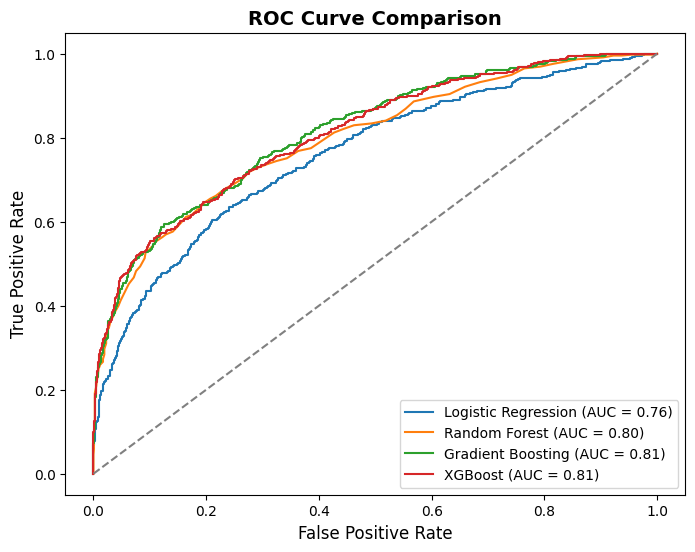

In [267]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probability scores for the positive class
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")

# Plot the diagonal line representing random classifier performance
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line

# Add labels and title
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve Comparison", fontsize=14, fontweight='bold')

# Show the legend
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [269]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
# Define hyperparameters to tune for XGBClassifier
param_grid = {
      "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
}

# Initialize model
xgb = XGBClassifier(learning_rate=0.1, objective='binary:logistic', random_state=0, eval_metric='mlogloss')

# Grid Search with 5-Fold Cross Validation
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters & best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC-ROC Score: {grid_search.best_score_:.4f}")

# Evaluate on test data
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
auc_roc_best = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])

print(f"Final AUC-ROC on Test Set: {auc_roc_best:.4f}")
print(classification_report(y_test, y_pred_best))

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best AUC-ROC Score: 0.9301
Final AUC-ROC on Test Set: 0.8045
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1244
           1       0.68      0.48      0.56       458

    accuracy                           0.80      1702
   macro avg       0.75      0.70      0.72      1702
weighted avg       0.79      0.80      0.79      1702



In [287]:
import torch
import numpy as np
import pandas as pd #Import pandas if you haven't already

def convert_to_torch_tensors(X_train, X_test, y_train, y_test):
    """
    Converts Pandas DataFrames (or NumPy arrays) to PyTorch tensors.

    Args:
        X_train (pandas.DataFrame or numpy.ndarray): Training features.
        X_test (pandas.DataFrame or numpy.ndarray): Testing features.
        y_train (pandas.Series or numpy.ndarray): Training labels.
        y_test (pandas.Series or numpy.ndarray): Testing labels.

    Returns:
        tuple: (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)
    """

    # Convert DataFrames/Series to NumPy arrays
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_train, pd.Series):
        y_train = y_train.values
    if isinstance(y_test, pd.Series):
        y_test = y_test.values

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    # Assuming y_train and y_test are classification labels (integers)
    # If they are regression targets (floats), use torch.float32
    if y_train.dtype == np.int64 or y_train.dtype == np.int32:
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    else:
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

In [288]:

# Import necessary libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

# Normalize the features (standardization)
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

#print(X_resampled.info())

# Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = convert_to_torch_tensors(X_train, X_test, y_train, y_test)

# Define the Deep Learning model
class StrokePredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(StrokePredictionModel, self).__init__()
        self.layer11 = nn.Linear(input_dim, 128)  # First hidden layer
        self.layer1 = nn.Linear(128, 64)  # First hidden layer
        self.layer2 = nn.Linear(64, 32)         # Second hidden layer
        self.layer3 = nn.Linear(32, 16)         # Third hidden layer
        self.output = nn.Linear(16, 2)          # Output layer (2 classes)

    def forward(self, x):
        x = torch.relu(self.layer11(x))
        x = torch.relu(self.layer1(x))  # Apply ReLU activation after each layer
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output(x)  # No activation function here for multi-class classification
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = StrokePredictionModel(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()  # Suitable for classification problems
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
# Define the model with class weights (in case of class imbalance)
class_weights = torch.tensor([1.0, 3.0])  # Assuming the 2nd class is underrepresented
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Early Stopping (monitor validation loss)
best_loss = float('inf')
patience = 5  # Number of epochs to wait before stopping if no improvement
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if loss.item() < best_loss:
        best_loss = loss.item()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement > patience:
        print("Early stopping triggered")
        break

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the model on the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)  # Forward pass
    _, predicted = torch.max(outputs, 1)  # Get predicted class labels

# Calculate accuracy
accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute classification report
print(classification_report(y_test_tensor, predicted))

# Compute AUC-ROC
y_prob = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for class 1
roc_auc = roc_auc_score(y_test_tensor, y_prob)
print(f"Test AUC-ROC: {roc_auc:.4f}")


Epoch [10/100], Loss: 0.6844
Epoch [20/100], Loss: 0.6590
Epoch [30/100], Loss: 0.6146
Epoch [40/100], Loss: 0.5602
Epoch [50/100], Loss: 0.5419
Epoch [60/100], Loss: 0.5273
Epoch [70/100], Loss: 0.5135
Epoch [80/100], Loss: 0.5001
Epoch [90/100], Loss: 0.4854
Epoch [100/100], Loss: 0.4706
Test Accuracy: 0.7256
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      2488
           1       0.49      0.68      0.57       916

    accuracy                           0.73      3404
   macro avg       0.68      0.71      0.68      3404
weighted avg       0.76      0.73      0.74      3404

Test AUC-ROC: 0.7776


In [245]:
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [258]:
class RandomBaselineClassifier(BaseEstimator, ClassifierMixin):
    """
    Random baseline classifier.
    """
    def __init__(self):
        self.labels_ = None
        self.probs_ = None

    def fit(self, x, y):
        """
        Fit the model. Save the labels and probability distribution across all classes.
        """
        x, y = check_X_y(x, y)
        self.labels_, self.probs_ = np.unique(y, return_counts=True)
        self.probs_ = self.probs_ / self.probs_.sum()
        return self

    def predict(self, x):
        """
        Predict the labels for the given data, making use of the probability distribution across all classes.
        """
        check_is_fitted(self)
        return np.random.choice(self.labels_, size=len(x), p=self.probs_)

def print_model_results(model_name: str, result_metrics: dict):
  """
  Print model results (from dictionary).
  """
  if result_metrics is None:
      result_metrics = dict()
  print(model_name)
  print(f'AUC (ROC) score:\t{result_metrics.get("AUC (ROC)", dict()).get(model_name, None)}')
  print(f'F1 score:\t\t{result_metrics.get("F1", dict()).get(model_name, None)}')
  print(f'Precision score:\t{result_metrics.get("Precision", dict()).get(model_name, None)}')
  print(f'Recall score:\t\t{result_metrics.get("Recall", dict()).get(model_name, None)}')
  print(f'Accuracy score:\t\t{result_metrics.get("Accuracy", dict()).get(model_name, None)}')
  print()

In [259]:
def evaluate_sklearn_binary_classification_models(x_tr, x_te, y_tr, y_te):
    """
    Evaluate sklearn binary classification models.
    """
    models = [LogisticRegression(),
              LinearSVC(max_iter=5_000),
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              GaussianNB(),
              KNeighborsClassifier(),
              RandomBaselineClassifier()]

    # Dictionaries to keep track of multiple metric score for each model
    roc_auc_scores = {}
    f1_scores = {}
    precision_scores = {}
    recall_scores = {}
    accuracy_scores = {}
    fpr_vals = {}
    tpr_vals = {}

    # Main results dictionary to track all metric scores for each model
    result_metrics = {'AUC (ROC)': roc_auc_scores, 'F1': f1_scores, 'Precision': precision_scores,
                      'Recall': recall_scores, 'Accuracy': accuracy_scores, 'fpr': fpr_vals, 'tpr': tpr_vals}

    # Train and evaluate each model
    for model in models:
        # Fit the model with train data
        model.fit(x_tr, y_tr)

        # Predict using test data
        y_te_predictions = model.predict(x_te)

        name = str(model).split("(")[0]

        # Calculate and store roc curve
        fpr, tpr, _ = roc_curve(y_te, y_te_predictions)
        fpr_vals[name] = fpr
        tpr_vals[name] = tpr

        # Calculate and store metric scores, i.e., AUC (ROC), F1, precision, recall, and accuracy
        roc_auc_scores[name] = roc_auc_score(y_te, y_te_predictions)
        f1_scores[name] = f1_score(y_te, y_te_predictions)
        precision_scores[name] = precision_score(y_te, y_te_predictions)
        recall_scores[name] = recall_score(y_te, y_te_predictions)
        accuracy_scores[name] = accuracy_score(y_te, y_te_predictions)

        # Print model results
        print_model_results(name, result_metrics)

    return result_metrics

In [32]:
results = evaluate_sklearn_binary_classification_models(X_train, X_test, y_train, y_test)

LogisticRegression
AUC (ROC) score:	0.5681055336160653
F1 score:		0.5534204458109147
Precision score:	0.5741626794258373
Recall score:		0.5341246290801187
Accuracy score:		0.5680297397769517

LinearSVC
AUC (ROC) score:	0.5658733808877313
F1 score:		0.5514592933947773
Precision score:	0.571656050955414
Recall score:		0.5326409495548962
Accuracy score:		0.5657992565055762

DecisionTreeClassifier
AUC (ROC) score:	0.5330500117190782
F1 score:		0.5409356725146199
Precision score:	0.5331412103746398
Recall score:		0.5489614243323442
Accuracy score:		0.533085501858736

RandomForestClassifier
AUC (ROC) score:	0.6334438169701098
F1 score:		0.6361623616236163
Precision score:	0.6328928046989721
Recall score:		0.6394658753709199
Accuracy score:		0.633457249070632

GaussianNB
AUC (ROC) score:	0.5058882840173884
F1 score:		0.061971830985915494
Precision score:	0.6111111111111112
Recall score:		0.032640949554896145
Accuracy score:		0.5048327137546469

KNeighborsClassifier
AUC (ROC) score:	0.58955586

In [248]:
def save_and_download_figure(fig_name: str, download: bool):
    """
    Save and download figure.
    """
    if download:
        plt.savefig(fig_name, bbox_inches='tight')
        # files.download(fig_name) # Assuming 'files' is available (e.g., in Colab)


def visualize_result_metrics(result_metrics: dict, download: bool):
    """
    Visualize result metrics.
    """
    # for each evaluation metric create a horizontal bar graph
    for eval_name in result_metrics:
        # skip fpr/tpr, these are separately used to plot ROC curve
        if eval_name in ('fpr', 'tpr'):
            continue

        # plot in horizontal bar graph all scores for the given metric
        scores = result_metrics[eval_name]
        fig, ax = plt.subplots()
        ind = range(len(scores))
        ax.barh(ind, list(scores.values()), align='center', alpha=0.8)

        # Add metric score to the end of bar graph
        for i in range(len(scores)):
            score = list(scores.values())[i]
            plt.text(score, i, "{:.4f}".format(score), ha='left')

        # Set x-axis labels, y-axis labels, and title
        ax.set_yticks(ind)
        ax.set_yticklabels(scores.keys())
        ax.set_xlabel(f'{eval_name} score')
        ax.tick_params(left=False, top=False, right=False)
        ax.set_title(f'{eval_name} score comparison of binary classification models')

        # Color red bar graph for Neural Network
        models = list(scores.keys())
        neural_network_index = models.index("Neural Network") if "Neural Network" in models else None
        if neural_network_index is not None:
            ax.get_children()[neural_network_index].set_color('r')

        # (optional) save and download the figure
        fig_name = f'{eval_name}_{neural_network_index}.png'
        save_and_download_figure(fig_name, download)
        plt.show()
        print()

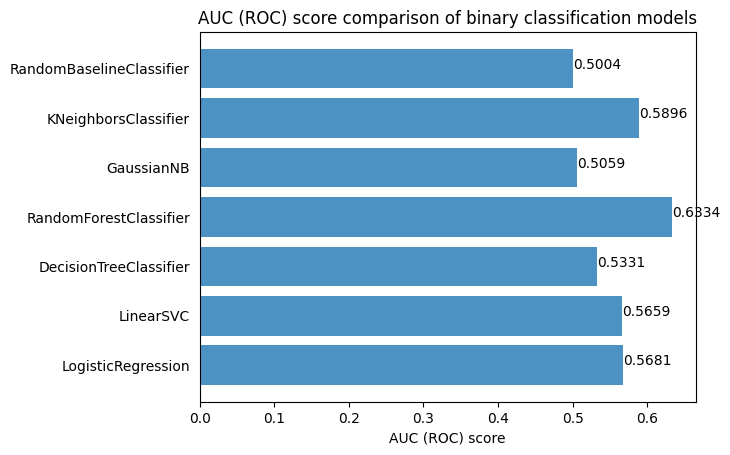

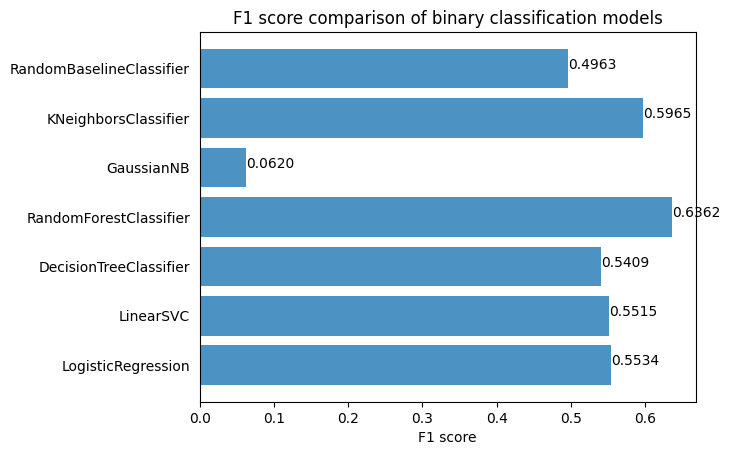

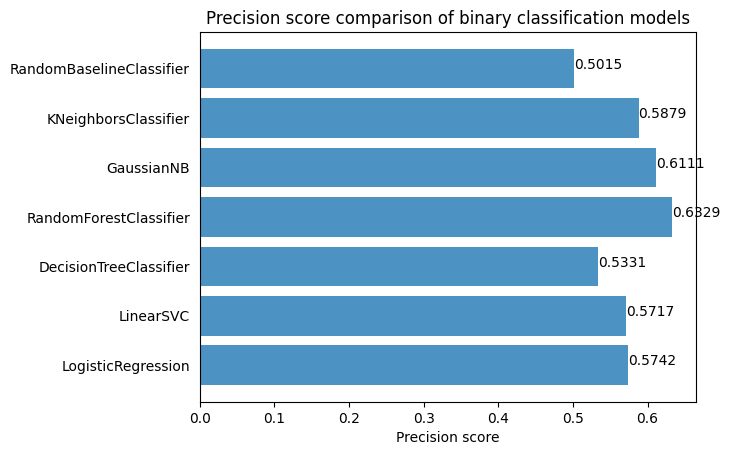

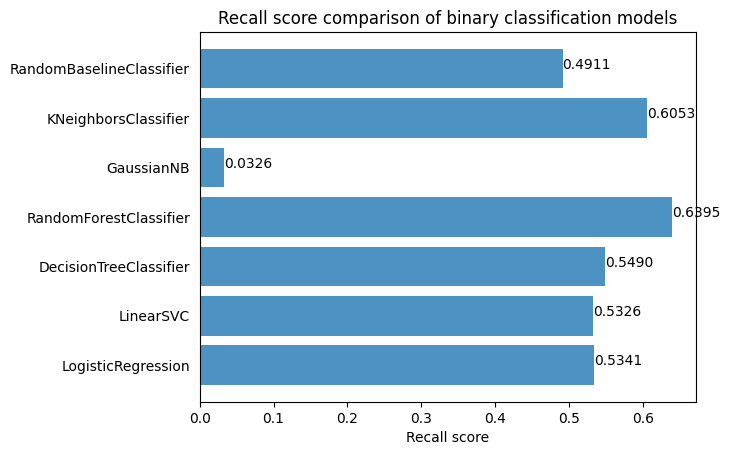

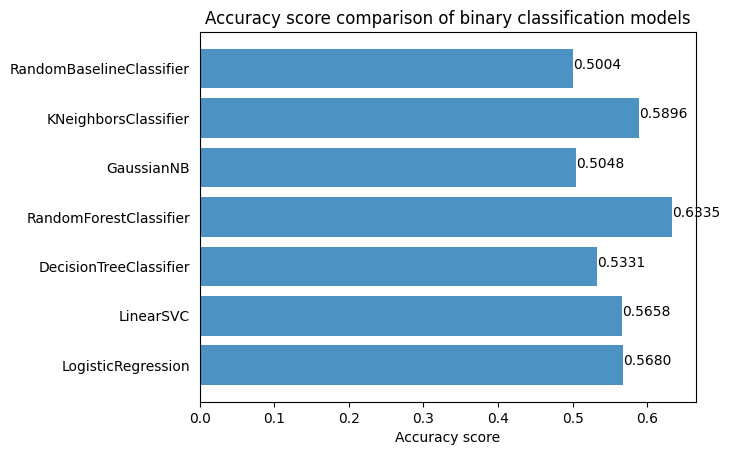

In [34]:
visualize_result_metrics(results, download=False)

In [249]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [250]:
import torch.nn as nn
class NeuralNetwork(nn.Module):
    """
    Neural Network model.
    """
    def __init__(self, input_size, hidden_layer_size):
        """
        Initialize Neural Network model. Input size is the number of features,
        hidden layer size is the number of neurons in the hidden layer.
        """
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_size, hidden_layer_size),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_layer_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass.
        """
        return self.sequential(x)

In [251]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    """
    Custom dataset class.
    """
    def __init__(self, x, y):
        """
        Initialize CustomDataset class.
        """
        self.x = torch.tensor(x.values).float().to(device)
        self.y = torch.tensor(y).float().unsqueeze(-1).to(device)
        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        """
        Get item.
        """
        return self.x[idx], self.y[idx]

    def __len__(self):
        """
        Get size of dataset.
        """
        return self.length

In [252]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn, optimizer):
    """
    Single epoch train loop.
    """
    # Aggregate running loss for single epoch train loop
    running_loss = 0.0

    # set model to train mode
    model.train()

    # iterate over all data in batches
    for _, (x, y) in enumerate(dataloader):
        # make model prediction
        pred = model(x)
        # calculate loss
        loss = loss_fn(pred, y)
        # perform one step of back propagation
        loss.backward()
        optimizer.step()
        # zero (reset) gradient
        optimizer.zero_grad()
        # update running loss
        running_loss += loss.item() * x.size(0)

    # return total train loss for epoch
    return running_loss / len(dataloader.dataset)

def eval_loop(dataloader: DataLoader, model: nn.Module, loss_fn):
    """
    Single epoch validation evaluation.
    """
    # set model to eval mode
    model.eval()

    # with no gradient, calculate loss function of model prediction on all data
    with torch.no_grad():
        x, y = next(iter(dataloader))
        pred = model(x)
        return loss_fn(pred, y).item()

In [253]:
def train(epochs: int, tr_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, va_dataloader: DataLoader):
    """
    Main train method. For a number of epochs, train and eval loops are called on neural network model and
    train/validation datasets. Train and validation losses returned as a result
    """
    train_losses = []
    val_losses = []

    for t in range(epochs):
        print(f"Epoch: {t+1}", end='\t')

        # Call train loop and append resulting loss
        train_loss = train_loop(tr_dataloader, model, loss_fn, optimizer)
        train_losses.append(train_loss)
        print(f"Train loss: {train_loss}", end='\t')

        # Call evaluation loop and append resulting loss
        val_loss = eval_loop(va_dataloader, model, loss_fn)
        val_losses.append(val_loss)
        print(f"Val loss: {val_loss}")
        print()

    print("Done!")

    # Return losses as pandas DataFrame
    return pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})


# Hyperparameters, number of epochs to train and batch size to use for training
EPOCHS = 1_000
BATCH_SIZE = 64

# Create data loaders for training, validation, and test datasets.
# Make use of batching only for training data.
train_dataloader = DataLoader(CustomDataset(X_train, y_train), batch_size=BATCH_SIZE)
val_dataloader = DataLoader(CustomDataset(X_val, y_val), batch_size=len(X_val))
test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size=len(X_test))

# Create Neural Network model with hidden layer size equal to 64
neural_network = NeuralNetwork(input_size=X_train.shape[-1], hidden_layer_size=64).to(device)

# We'll make use of Adam optimizer
adam_optimizer = torch.optim.Adam(neural_network.parameters())

# We'll make use of binary cross entropy loss function for training
bce_loss = nn.BCELoss()

In [42]:
losses = train(EPOCHS, train_dataloader, neural_network, bce_loss, adam_optimizer, val_dataloader)

Epoch: 1	Train loss: 0.6812735654375599	Val loss: 0.67326420545578

Epoch: 2	Train loss: 0.6709225309166671	Val loss: 0.6664958000183105

Epoch: 3	Train loss: 0.6697155459128885	Val loss: 0.6664036512374878

Epoch: 4	Train loss: 0.6663116692055774	Val loss: 0.664953351020813

Epoch: 5	Train loss: 0.6641092752978061	Val loss: 0.6639546155929565

Epoch: 6	Train loss: 0.6623752706137329	Val loss: 0.6635460257530212

Epoch: 7	Train loss: 0.6598966557416512	Val loss: 0.6634138226509094

Epoch: 8	Train loss: 0.6608522844142772	Val loss: 0.66260826587677

Epoch: 9	Train loss: 0.6596682929565939	Val loss: 0.6625691652297974

Epoch: 10	Train loss: 0.6594067167094119	Val loss: 0.6631569862365723

Epoch: 11	Train loss: 0.6600956587307069	Val loss: 0.6639013886451721

Epoch: 12	Train loss: 0.6601420999709422	Val loss: 0.6615651249885559

Epoch: 13	Train loss: 0.6592852879545956	Val loss: 0.661644458770752

Epoch: 14	Train loss: 0.656861625020862	Val loss: 0.6622111201286316

Epoch: 15	Train loss: 

In [254]:
def metric_score_eval(y_true, y_pred, metric, threshold=None):
    """
    Calculate metric score given true and predicted values.
    """
    y_pred = y_pred.squeeze().cpu().detach().numpy()

    # for binary classification, if threshold is specified, set prediction accordingly
    if threshold is not None:
        y_pred = np.where(y_pred > threshold, 1, 0)

    return metric(y_true.squeeze().cpu().detach().numpy(), y_pred)

def evaluate_neural_network(dataloader: DataLoader, model: nn.Module, result_metrics: dict = None):
    """
    Evaluate neural network model on test dataset.
    """
    # create result metrics (dictionary) if None passed in
    if result_metrics is None:
        result_metrics = {'AUC (ROC)': {}, 'F1': {}, 'Precision': {}, 'Recall': {}, 'Accuracy': {}, 'fpr': {}, 'tpr': {}}

    # set model to eval mode
    model.eval()

    # with no gradient, calculate loss function of model prediction on all data
    with torch.no_grad():
        x, y = next(iter(dataloader))
        model_name = model.__class__.__name__

        # model prediction on test data
        pred = model(x)

        # calculate ROC curve
        fpr, tpr, thresholds = metric_score_eval(y, pred, lambda y_true, y_pred: roc_curve(y_true, y_pred))
        result_metrics['fpr'][model_name] = fpr
        result_metrics['tpr'][model_name] = tpr

        # find the best threshold from ROC curve. Best is threshold that gives highest F1 score
        best_threshold = float('inf')
        best_f1_score = float('-inf')

        for threshold in thresholds:
            # calculate F1 score for threshold
            f1 = metric_score_eval(y, pred, lambda y_true, y_pred: f1_score(y_true, y_pred), threshold=threshold)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold

        # calculate AUC (ROC) score
        result_metrics['AUC (ROC)'][model_name] = metric_score_eval(y, pred, lambda y_true, y_pred: roc_auc_score(y_true, y_pred))
        # calculate F1 score
        result_metrics['F1'][model_name] = best_f1_score
        result_metrics['Precision'][model_name] = metric_score_eval(y, pred, lambda y_true, y_pred: precision_score(y_true, y_pred),
                                                                   threshold=best_threshold)
        # calculate recall
        result_metrics['Recall'][model_name] = metric_score_eval(y, pred, lambda y_true, y_pred: recall_score(y_true, y_pred),
                                                                threshold=best_threshold)
        result_metrics['Accuracy'][model_name] = metric_score_eval(y, pred, lambda y_true, y_pred: accuracy_score(y_true, y_pred),
                                                                  threshold=best_threshold)

        # print results
        print_model_results(model_name, result_metrics)

    # return result metrics dictionary
    return result_metrics

In [44]:
results = evaluate_neural_network(test_dataloader, neural_network, results)

NeuralNetwork
AUC (ROC) score:	0.6536127928111194
F1 score:		0.6853473438412142
Precision score:	0.5649663137632339
Recall score:		0.870919881305638
Accuracy score:		0.5992565055762081



In [255]:
def plot_roc_curve(model_name: str, fpr, tpr, download: bool):
    """
    Plots a ROC curve given the false positive rate (fpr) and true positive rate (tpr) of a model.
    Code from https://jovian.com/vipul0036vipul/how-to-find-optimal-threshold-for-binary-classification-roc-curve
    """
    plt.plot(fpr, tpr, color="orange", label='ROC')
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    fig_name = f'{model_name}_roc_curve.png'
    save_and_download_figure(fig_name, download)
    plt.show()

def plot_all_roc_curves(result_metrics: dict, download: bool):
    """
    Plots all ROC curves.
    """
    for model_name in set(result_metrics['fpr'].keys()).union(set(result_metrics['tpr'].keys())):
        plot_roc_curve(model_name, result_metrics['fpr'][model_name], result_metrics['tpr'][model_name],
                       download=download)
        print()

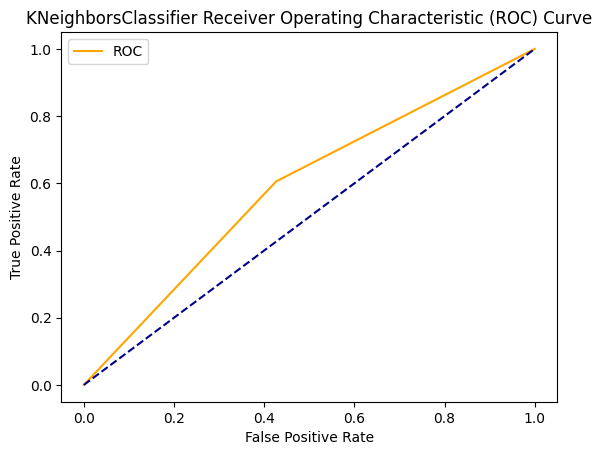

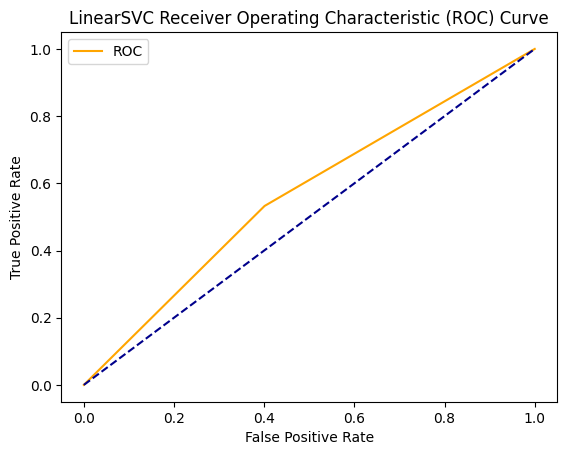

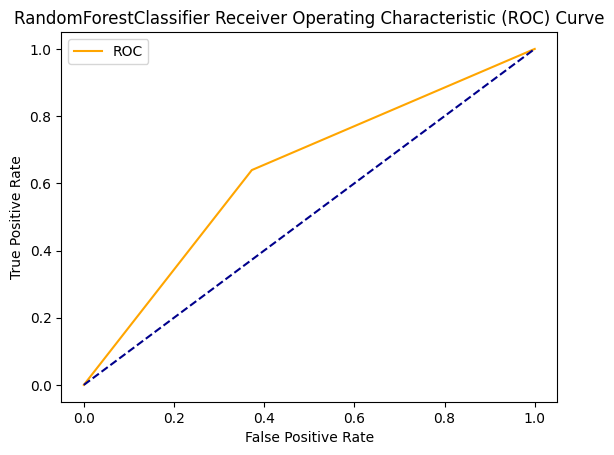

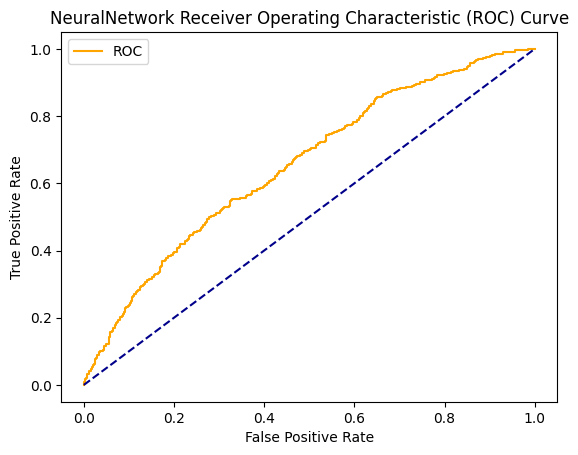

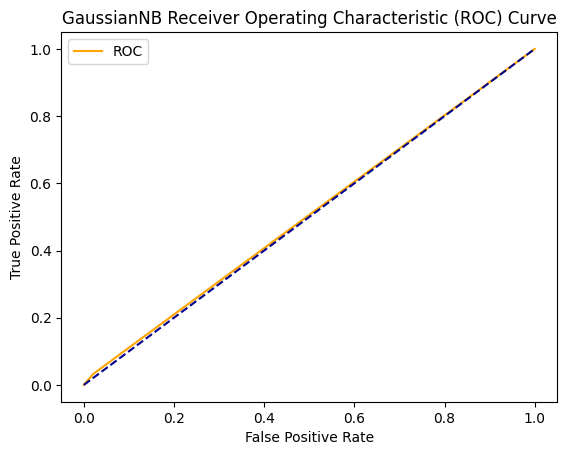

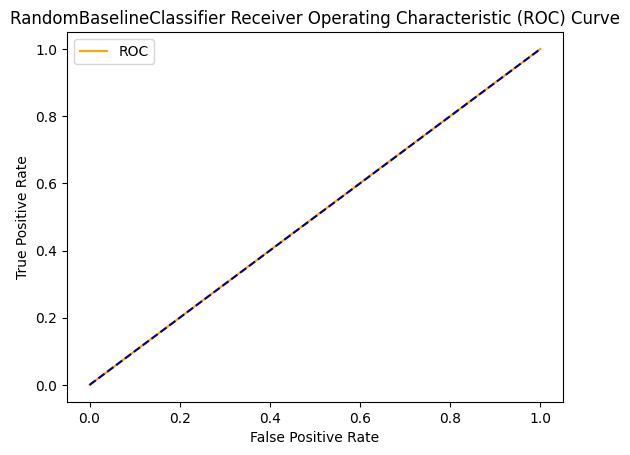

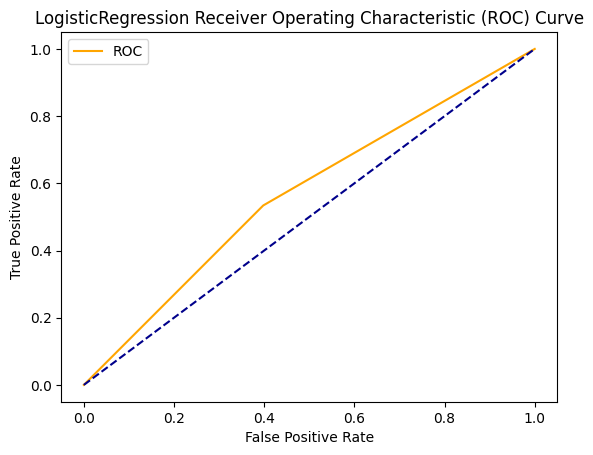

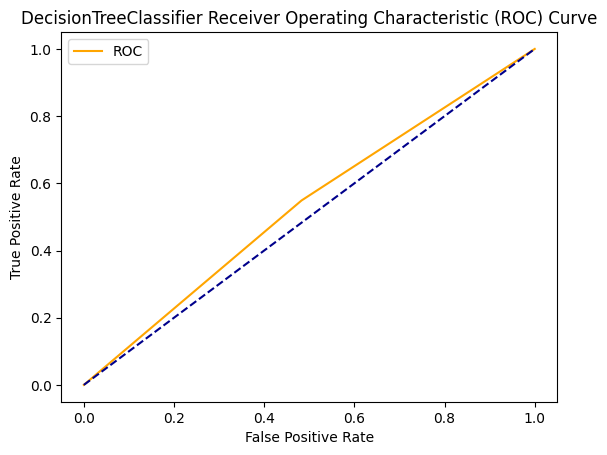

In [46]:
plot_all_roc_curves(results, download=False)